# Example of using the model module
This notebook shows how to use the components defined in the model. The model module is meant as a light-weight trade model which allows flexible portfolio construction and valuation. The portfolio then handles the position management (long/short), and p&l accounting.

In [1]:
import tia.analysis.model as model
import pandas as pd

from tia.util.fmt import new_dynamic_formatter, DynamicColumnFormatter

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    plt.style.use('fivethirtyeight')
    plt.rcParams['lines.linewidth'] = 1.4
except:
    pass

In [3]:
# Load microsoft - note it retrieves the dividends too
msft = model.load_yahoo_stock('MSFT', start='1/1/2010')
msft.pxs.frame.tail()

C:\Anaconda\lib\site-packages\pandas\tseries\base.py:363: FutureWarning: using '-' to provide set differences with datetimelike Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)
C:\Anaconda\lib\site-packages\pandas\core\index.py:1196: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)


,open,high,low,close,volume,adj close,dvds
Date,,,,,,,
2015-04-20,41.73,43.17,41.68,42.91,45738800,42.91,NaN
2015-04-21,43.00,43.15,42.53,42.64,25932200,42.64,NaN
2015-04-22,42.67,43.13,42.55,42.99,24856600,42.99,NaN
2015-04-23,42.89,43.61,42.80,43.34,45029600,43.34,NaN
2015-04-24,45.66,48.14,45.65,47.87,127995200,47.87,NaN


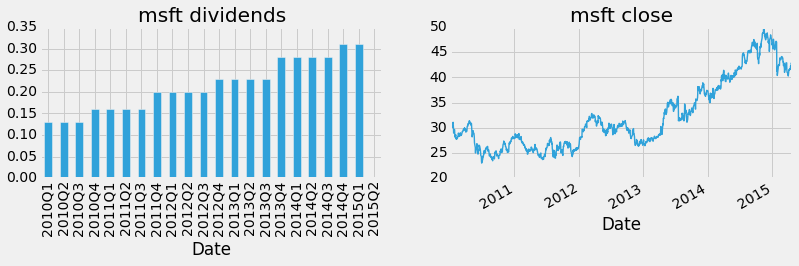

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
msft.pxs.dvds.resample('Q', how='sum').to_period().plot(kind='bar', ax=axes[0], title='msft dividends')
msft.pxs.close.plot(ax=axes[1], title='msft close')

In [5]:
#
# Create a signal for when the 10x20 moving average (buy/sell single contract)
# - you can create your own simulation and build trades (using model.Trade or
#   model.TradeBlotter)
from tia.analysis.ta import cross_signal, sma, Signal
ma10, ma20 = sma(msft.pxs.close, 10), sma(msft.pxs.close, 20)
sig = cross_signal(ma10, ma20)
trades = Signal(sig).close_to_close(msft.pxs.close)
# show last 10 trades
trades[-10:]

[<Trade(108, qty=1.0, px=46.45, ts=2014-12-31 00:00:00)>,
 <Trade(109, qty=1.0, px=46.45, ts=2014-12-31 00:00:00)>,
 <Trade(110, qty=-1.0, px=47.59, ts=2015-01-08 00:00:00)>,
 <Trade(111, qty=-1.0, px=47.59, ts=2015-01-08 00:00:00)>,
 <Trade(112, qty=1.0, px=43.86, ts=2015-02-20 00:00:00)>,
 <Trade(113, qty=1.0, px=43.86, ts=2015-02-20 00:00:00)>,
 <Trade(114, qty=-1.0, px=42.03, ts=2015-03-10 00:00:00)>,
 <Trade(115, qty=-1.0, px=42.03, ts=2015-03-10 00:00:00)>,
 <Trade(116, qty=1.0, px=41.62, ts=2015-04-17 00:00:00)>,
 <Trade(117, qty=1.0, px=41.62, ts=2015-04-17 00:00:00)>]

In [6]:
# Build the portfolio
port = model.SingleAssetPortfolio(msft, trades)

In [7]:
# show the ltd transaction level pl frame
port.pl.ltd_txn_frame.tail()

,date,pos,pid,tid,txn_qty,txn_px,txn_fees,txn_premium,txn_intent,txn_action,close,open_val,mkt_val,total_val,dvds,fees,rpl_gross,rpl,upl,pl
1389,2015-04-20,1,59,0,NaN,NaN,0,0,0,0,42.91,-41.62,42.91,-36.55,0.44,0,5.07,5.51,1.29,6.80
1390,2015-04-21,1,59,0,NaN,NaN,0,0,0,0,42.64,-41.62,42.64,-36.55,0.44,0,5.07,5.51,1.02,6.53
1391,2015-04-22,1,59,0,NaN,NaN,0,0,0,0,42.99,-41.62,42.99,-36.55,0.44,0,5.07,5.51,1.37,6.88
1392,2015-04-23,1,59,0,NaN,NaN,0,0,0,0,43.34,-41.62,43.34,-36.55,0.44,0,5.07,5.51,1.72,7.23
1393,2015-04-24,1,59,0,NaN,NaN,0,0,0,0,47.87,-41.62,47.87,-36.55,0.44,0,5.07,5.51,6.25,11.76


In [8]:
# show the daily pl frame (rolled up by day)
port.pl.dly_frame.tail()

,dvds,fees,rpl_gross,rpl,upl,pl
2015-04-20,0,0,0,0,1.29,1.29
2015-04-21,0,0,0,0,-0.27,-0.27
2015-04-22,0,0,0,0,0.35,0.35
2015-04-23,0,0,0,0,0.35,0.35
2015-04-24,0,0,0,0,4.53,4.53


In [9]:
# show the positions
F = new_dynamic_formatter(method='col', pcts=1, parens=0, trunc_dot_zeros=1)
F(port.positions.frame.tail(4))

,side,open_dt,close_dt,open_qty,open_px,close_px,open_premium,pl,ret,duration,ntxns,state
pid,,,,,,,,,,,,
56,Short,2015-01-08,2015-02-20,-1,47.6,43.9,47.6,3.4,7.2%,30,2,Closed
57,Long,2015-02-20,2015-03-10,1,43.9,42,-43.9,-1.8,-4.2%,13,2,Closed
58,Short,2015-03-10,2015-04-17,-1,42,41.6,42,0.4,1%,28,2,Closed
59,Long,2015-04-17,2015-04-24,1,41.6,nan,-41.6,6.3,15%,6,1,Open


In [10]:
# Look at basic p/l stats
PLFMT = new_dynamic_formatter(method='row', precision=3, pcts=1, trunc_dot_zeros=1)

tmp = pd.DataFrame({'dly': port.pl.dly_details.summary, 
              'wkly': port.pl.weekly_details.summary, 
              'mthly': port.pl.monthly_details.summary, 
              'yrly': port.pl.annual_details.summary})
PLFMT(tmp)

,dly,mthly,wkly,yrly
avg,0.009,0.184,0.042,1.960
std,0.474,2.195,1.094,5.609
maxdd,(14.200),(12.410),(13.080),(7.870)
maxdd dt,08-Nov-11,31-Jan-13,13-Nov-11,31-Dec-12
dd avg,(2.296),(8.320),(3.830),(7.870)
cnt,"1,336",64,277,6


In [11]:
FMT = new_dynamic_formatter(method='row', precision=2, pcts=1, trunc_dot_zeros=1)

In [12]:
# Look at basic ret stats (By default return on initial invest of each position)
tmp = pd.DataFrame({'dly': port.performance.dly_details.summary, 
              'wkly': port.performance.weekly_details.summary, 
              'mthly': port.performance.monthly_details.summary, 
              'yrly': port.performance.annual_details.summary})
FMT(tmp)

c:\projects\good_to_see_you\tia\tia\analysis\perf.py:93: UserWarning: frequency not set. guessed it to be B
  warnings.warn('frequency not set. guessed it to be %s' % freq)


,dly,mthly,wkly,yrly
ltd,8.52%,8.52%,8.52%,8.52%
ltd ann,1.55%,1.54%,1.55%,1.37%
mean,0.02%,0.34%,0.08%,2.68%
mean ann,4.02%,4.07%,4.12%,2.68%
std,1.40%,6.56%,3.17%,17.50%
std ann,22.27%,22.73%,22.89%,17.50%
sharpe ann,6.98%,6.80%,6.76%,7.84%
sortino,7%,6.76%,6.89%,9.28%
maxdd,(44.86%),(41.89%),(42.80%),(32.14%)
maxdd dt,08-Nov-11,31-Jan-13,13-Nov-11,31-Dec-12


In [13]:
# show the position stats
port.positions.stats

,positions
cnt,59
win_pct,44.07%
ret_avg,0.36%
ret_std,6.99%
ret_min,(9.55%)
ret_max,27.24%
pl_avg,19.93%
pl_std,2.12
pl_min,(2.74)
pl_max,6.95


In [14]:
# Easy to get portfolio subsets such as long/short, winner/losers
port.long.positions.frame.tail()

,side,open_dt,close_dt,open_qty,open_px,close_px,open_premium,pl,ret,duration,ntxns,state
pid,,,,,,,,,,,,
51,Long,2014-08-19,2014-10-02,1,45.33,45.76,-45.33,0.71,0.015663,32,2,Closed
53,Long,2014-10-30,2014-11-28,1,46.05,47.81,-46.05,2.07,0.044951,21,2,Closed
55,Long,2014-12-31,2015-01-08,1,46.45,47.59,-46.45,1.14,0.024543,6,2,Closed
57,Long,2015-02-20,2015-03-10,1,43.86,42.03,-43.86,-1.83,-0.041724,13,2,Closed
59,Long,2015-04-17,2015-04-24,1,41.62,NaN,-41.62,6.25,0.150168,6,1,Open


In [15]:
# Get a specific position
pos = port.long.positions[57]


In [20]:
# Get txn level detail associated with the position
pos.pl.txn_frame.head()

,date,pos,pid,tid,txn_qty,txn_px,txn_fees,txn_premium,txn_intent,txn_action,close,open_val,mkt_val,total_val,dvds,fees,rpl_gross,rpl,upl,pl
1291,2015-02-20,1,57,113,1,43.86,0,-43.86,1,1,43.86,-43.86,43.86,-43.86,0,0,0,0,0.00,0.00
1292,2015-02-23,1,57,0,NaN,NaN,0,0.00,0,0,44.15,-43.86,44.15,0.00,0,0,0,0,0.29,0.29
1293,2015-02-24,1,57,0,NaN,NaN,0,0.00,0,0,44.09,-43.86,44.09,0.00,0,0,0,0,-0.06,-0.06
1294,2015-02-25,1,57,0,NaN,NaN,0,0.00,0,0,43.99,-43.86,43.99,0.00,0,0,0,0,-0.10,-0.10
1295,2015-02-26,1,57,0,NaN,NaN,0,0.00,0,0,44.06,-43.86,44.06,0.00,0,0,0,0,0.07,0.07


### Simple Report Provided (can add own splits but Long/Short, Win/Loss included)

In [21]:
summary = model.PortfolioSummary()
# defaults included are long/short, win/loss but can provide a method to split as like
summary.include_long_short().include_win_loss()

# a few simple stats methods provided but easy to create own
analyze_fct = model.PortfolioSummary.analyze_returns
rpt = summary(port, analyze_fct)
FMT(rpt.T)

lvl1                     All                             long             \
lvl2                     All     winner      loser        All     winner   
port ltd ann           1.54%     30.89%   (22.42%)      7.72%     21.84%   
     mret avg          0.34%      2.38%    (2.04%)      0.75%      1.74%   
     mret avg ann      4.07%     28.56%   (24.44%)      8.96%     20.90%   
     mret std ann     22.73%     16.85%     11.44%     17.64%     14.44%   
     sharpe ann         0.07       1.83     (1.96)       0.44       1.51   
     sortino            0.07       2.26     (1.18)       0.49       1.48   
     maxdd          (44.86%)   (16.68%)   (75.06%)   (26.22%)   (12.82%)   
     maxdd dt      08-Nov-11  08-Nov-11  10-Mar-15  01-Nov-11  08-Aug-11   
     avg dd          (6.62%)    (2.79%)   (25.27%)    (3.77%)    (2.45%)   
     nmonths              64         64         64         64         64   
pos  cnt                  59         26         33         30         15   
     win cnt              26         26          0         15         15   
     lose cnt             33          0         33         15          0   
     winpct             0.44          1          0       0.50          1   
     ret avg           0.36%      5.88%    (3.99%)      1.65%      7.57%   
     ret std           6.99%      6.98%      2.49%      8.55%      8.43%   
     ret min         (9.55%)      0.07%    (9.55%)    (9.55%)      0.12%   
     ret max          27.24%     27.24%    (0.22%)     27.24%     27.24%   
     dur avg           23.03      33.38      14.88      26.47      38.33   
     dur max             104        104         37        104        104   

lvl1                              short                        
lvl2                   loser        All     winner      loser  
port ltd ann        (11.59%)    (5.73%)      7.42%   (12.25%)  
     mret avg        (0.99%)    (0.41%)      0.63%    (1.04%)  
     mret avg ann   (11.93%)    (4.93%)      7.60%   (12.53%)  
     mret std ann      8.01%     14.02%      9.48%      9.52%  
     sharpe ann       (1.45)     (0.41)       0.78     (1.29)  
     sortino          (0.76)     (0.34)       0.69     (0.70)  
     maxdd          (49.92%)   (43.77%)    (8.81%)   (51.61%)  
     maxdd dt      10-Mar-15  04-Dec-14  24-Mar-15  08-Oct-14  
     avg dd         (16.89%)   (17.85%)    (3.45%)   (51.61%)  
     nmonths              64         64         64         64  
pos  cnt                  15         29         11         18  
     win cnt               0         11         11          0  
     lose cnt             15         18          0         18  
     winpct                0       0.38          1          0  
     ret avg         (4.26%)    (0.97%)      3.59%    (3.76%)  
     ret std           2.32%      4.69%      3.53%      2.68%  
     ret min         (9.55%)    (8.24%)      0.07%    (8.24%)  
     ret max         (1.06%)     10.63%     10.63%    (0.22%)  
     dur avg           14.60      19.48      26.64      15.11  
     dur max              37         43         43         28

### Some graphs

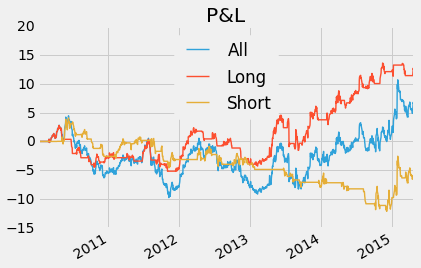

In [22]:
tmp = pd.DataFrame({'Long': port.long.pl.ltd_dly, 'Short': port.short.pl.ltd_dly, 'All': port.pl.ltd_dly})
_ = tmp.plot(title='P&L')

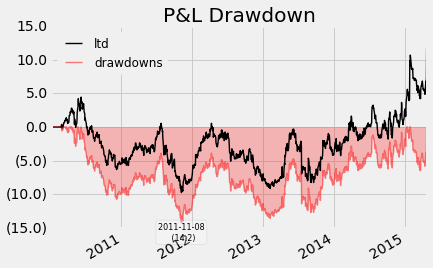

In [24]:
# Show Daily Drawdowns
port.pl.dly_details.plot_ltd()
plt.title('P&L Drawdown')

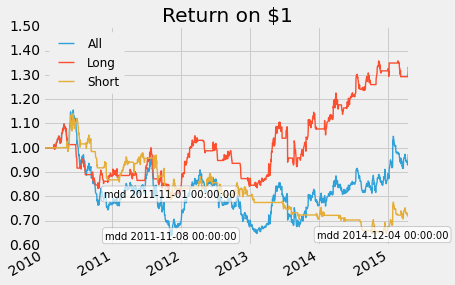

In [28]:
port.performance.dly_details.plot_ret_on_dollar(label='All')
port.long.performance.dly_details.plot_ret_on_dollar(label='Long')
port.short.performance.dly_details.plot_ret_on_dollar(label='Short')
plt.legend(loc='upper left', prop={'size':12})
plt.title('Return on $1')

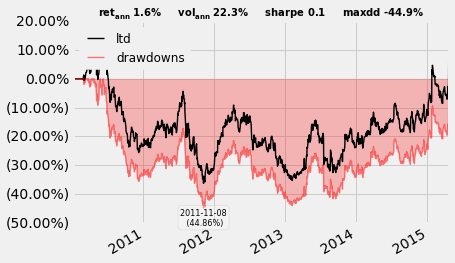

In [39]:
# Show the LTD Returns
port.performance.dly_details.plot_ltd()


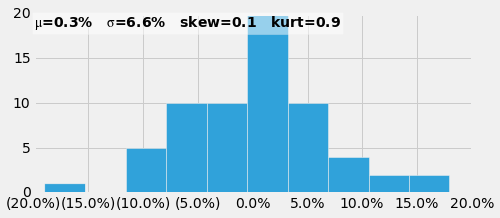

In [47]:
# Show the Monthly Return Histogram
port.performance.monthly_details.plot_hist(figsize=(7, 3))

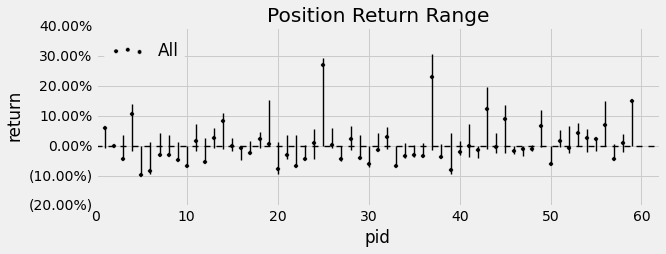

In [50]:
# See the range of returns for the positions
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
port.positions.plot_ret_range(ax=ax)
plt.title('Position Return Range')